In [1]:
import sys
sys.path.append('..')

In [2]:
from data import dataset, generate_data
from models import RSSM, MultiRSSM, VCD
import json
from jax import random
from jax import numpy as jnp
import flax
from flax import serialization
from matplotlib import pyplot as plt
import os

In [14]:
def rollout_error(dataloader, model_class, run_path, checkpoint_id, observation_steps):
    model_conf = json.load(open(os.path.join(run_path, 'model_conf.json')))
    model = model_class(
        latent_dim=model_conf["latent_dim"],
        action_dim=2,
        hidden_dim=model_conf["hidden_dim"],
        obs_dim=12,
        n_env=len(data_conf["train_data_conf"]["interventions"]),
    )

    rng, key = random.split(random.PRNGKey(model_conf["random_seed"]))
    state = model.init_train_state(rng, dataloader[0], lr=model_conf["lr"])
    state_dict = jnp.load(os.path.join(run_path, f'model_checkpoint_{checkpoint_id}.npy'), allow_pickle=True).item()['state_dict']
    state = serialization.from_state_dict(state, state_dict)

    log = []
    carry = model.get_init_carry(model_conf['hidden_dim'], model_conf['latent_dim'], 2, test_data[0][0][0], state_dict['params']['params'], rng)
    episode_length = dataloader[0][0].shape[0]
    for i in range(episode_length):
        if i <= observation_steps:
            carry, out = model.apply(state.params, carry, test_data[0][0][i], test_data[0][1][i], method=model.rollout)
        else:
            carry, out = model.apply(state.params, carry, None, test_data[0][1][i], method=model.rollout)
        log.append(jnp.median(((out[0]-test_data[0][0][i])**2).sum(-1).mean(-1)))
    return log

In [4]:
data_conf = json.load(open('../data/mixed_state_data_conf.json'))
test_data_config = data_conf['test_data_conf']
mixing_matrix = random.normal(random.PRNGKey(0), (8, 12))
mixing_function = lambda x: x @ mixing_matrix

In [5]:
test_data = dataset.DataLoader(
    generate_data.get_states,
    test_data_config,
    200,
    data_conf["test_data_seed"],
    mixing_function,
)

In [26]:
rssm_log = rollout_error(test_data, RSSM.RSSM, '../runs/RSSM', 2200, 100)
multi_log = rollout_error(test_data, MultiRSSM.MultiRSSM, '../runs/MultiRSSM/', 2200, 100)
vcd_log = rollout_error(test_data, VCD.VCD, '../runs/VCD/', 400, 100)

(0.0, 30.0)

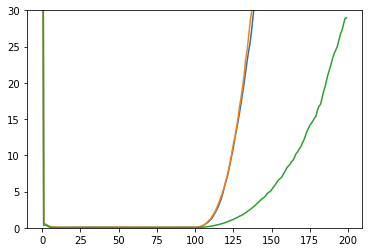

In [27]:
plt.plot(rssm_log)
plt.plot(multi_log)
plt.plot(vcd_log)
plt.ylim([0,30])

In [20]:
rssm_log[10]

DeviceArray(0.07878934, dtype=float32)